In [2]:
## STANDARD PYTHON LIBS
import os
import re
import sys
import cv2
import PIL
import math
import time
import random
import scipy.misc
import skimage.io
import skimage.transform
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
from src.model import log
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize

# GPU LIBS
import keras
import tensorflow as tf

print ('TF : ', tf.__version__, '  Keras : ', keras.__version__)

# if utils.check_gpu(verbose=1):
#     pass
# else:
#     sys.exit(1)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TF :  1.6.0   Keras :  2.1.4


Using TensorFlow backend.


# CUSTOMIZATION

In [3]:
class MapillaryConfig(Config):
    NAME = "mapillary"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    NUM_CLASSES = 1 + 14  # background + 3 shapes
    # [ '1' '17' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '8']
    
    IMAGE_MAX_DIM = 512
    
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    
    TRAIN_ROIS_PER_IMAGE = 30
    ROI_POSITIVE_RATIO = 0.9
    
    STEPS_PER_EPOCH = 10
    VALIDATION_STEPS = 2
    
config = MapillaryConfig()
config.BACKBONE_SHAPES
# config.display()

array([[128, 128],
       [ 64,  64],
       [ 32,  32],
       [ 16,  16],
       [  8,   8]])

In [4]:
class MapillaryDataset(utils.Dataset):
    
    def add_classes(self):
        self.dataset = 'mapillary'
        # self.add_class(self.dataset, 0, "unlabelled")
        self.add_class(self.dataset, 1, "void-ego vehicle")
        self.add_class(self.dataset, 8, "flat-sidewalk")
        self.add_class(self.dataset, 17, "object-pole")
        self.add_class(self.dataset, 23, "sky-sky")
        self.add_class(self.dataset, 24, "human-person")
        self.add_class(self.dataset, 25, "human-rider")
        self.add_class(self.dataset, 26, "vehicle-car")
        self.add_class(self.dataset, 27, "vehicle-truck")
        self.add_class(self.dataset, 28, "vehicle-bus")
        self.add_class(self.dataset, 29, "vehicle-caravan")
        self.add_class(self.dataset, 30, "vehicle-trailer")
        self.add_class(self.dataset, 31, "vehicle-train")
        self.add_class(self.dataset, 32, "vehicle-motorcycle")
        self.add_class(self.dataset, 33, "vehicle-bicycle")
    
    def add_image_mapillary(self, image_id, image_folder_path, image_file_name):
        image_path = os.path.join(image_folder_path, image_file_name)
        self.add_image(self.dataset, image_id=image_id, path=None,
                       image_folder_path=image_folder_path, image_file_name=image_file_name)
    
    def load_image(self, image_id):
        image_folder_path = self.image_info[image_id]['image_folder_path']
        image_file_name   = self.image_info[image_id]['image_file_name']
        img = skimage.io.imread(os.path.join(image_folder_path, image_file_name))
        return self.helper_img_shrink(img)
    
    def load_mask(self, image_id):
        image_folder_path = self.image_info[image_id]['image_folder_path']
        image_file_name   = self.image_info[image_id]['image_file_name']
        mask_file_name    = image_file_name.split('.jpg')[0] + '.npz'
        mask_file_path    = os.path.join(image_folder_path, mask_file_name)
        
        masks_res_tmp     = []
        class_ids_orig    = []
        class_ids_res     = []
        masks_sparse = np.load(mask_file_path)
        for class_id in masks_sparse:
            for instance_id in masks_sparse[class_id].item():
                mask_class_instance = np.array(masks_sparse[class_id].item()[instance_id].todense())
                masks_res_tmp.append(self.helper_img_shrink(mask_class_instance))
                class_ids_orig.append(class_id)
                class_ids_res.append(self.map_source_class_id(self.dataset + '.' + class_id))
        
        h, w = masks_res_tmp[0].shape
        masks_res = np.zeros([h, w, len(masks_res_tmp)], dtype=np.uint8)
        for i, mask in enumerate(masks_res_tmp):
            masks_res[:, :, i] = mask
        
#         print("image_id", image_id, "orig classes", class_ids_orig, "new classes", class_ids_res)
        return np.array(masks_res), np.array(class_ids_res).astype(np.uint32)
    
    def helper_img_shrink(self, img, MAX_DIM=512, show=0, verbose=0):
        if verbose : print ('-->', img.shape, list(np.unique(img)))
        if len(img.shape) == 3      : (r, c, ch) = img.shape
        elif len(img.shape) == 2    : (r, c)   = img.shape
        if r > c:
            new_r = MAX_DIM
            new_c = round(c / r * MAX_DIM)
        else:
            new_c = MAX_DIM
            new_r = round(r / c * MAX_DIM)
        img_trans = skimage.transform.resize(img, (new_r, new_c), preserve_range=True, mode='reflect').astype('uint8')
#         img_trans = np.array(img_trans, dtype = np.uint16)
        if verbose : print ('-------->', img_trans.shape, list(np.unique(img_trans)))
        if show:
            f,axarr = plt.subplots(1,2, figsize=(15,15))
            axarr[0].imshow(img)
            axarr[1].imshow(img_trans)
        return img_trans

if __name__ == "__main__":
    trainData = MapillaryDataset()
    trainData.add_classes()
    trainData.add_image_mapillary(0, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.add_image_mapillary(1, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.add_image_mapillary(2, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.add_image_mapillary(3, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.add_image_mapillary(4, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.add_image_mapillary(5, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.add_image_mapillary(6, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.add_image_mapillary(7, './raw/data', '_1AbvbARvB-5S0rAPN02Mg.jpg')
    trainData.prepare()
    
    valData = MapillaryDataset()
    valData.add_classes()
    valData.add_image_mapillary(0, './raw/data', '_2g1p_iHAUNc2KTgESz5KA.jpg')
    valData.add_image_mapillary(1, './raw/data', '_2g1p_iHAUNc2KTgESz5KA.jpg')
    valData.add_image_mapillary(2, './raw/data', '_2g1p_iHAUNc2KTgESz5KA.jpg')
    valData.add_image_mapillary(3, './raw/data', '_2g1p_iHAUNc2KTgESz5KA.jpg')
    valData.prepare()

In [8]:
img = trainData.load_image(0)
masks, class_ids = trainData.load_mask(0)
print (img.shape, img.dtype, masks.shape, class_ids.shape)
print ('--> Classes : ', np.unique(class_ids))
print ('Total Size : %.04f' % ((img.nbytes + masks.nbytes + class_ids.nbytes)/2**20), ' MB')

(384, 512, 3) uint8 (384, 512, 16) (16,)
--> Classes :  [ 2  3  4  5  7  8  9 13]
Total Size : 3.5626  MB


In [9]:
img = valData.load_image(0)
masks, class_ids = valData.load_mask(0)
print (img.shape, img.dtype, masks.shape, class_ids.shape)
print ('--> Classes : ', np.unique(class_ids))
print ('Total Size : %.04f' % ((img.nbytes + masks.nbytes + class_ids.nbytes)/2**20), ' MB')

(384, 512, 3) uint8 (384, 512, 9) (9,)
--> Classes :  [2 3 4 7 8 9]
Total Size : 2.2500  MB


# TRAINING

In [6]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'demo', 'model', "mask_rcnn_coco.h5")
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last()[1], by_name=True)


--------------------------
[play] rois : (8, ?, ?)
[play] target_class_ids : (8, ?)
[play] target_bbox : Tensor("proposal_targets/target_bbox:0", shape=(8, ?, ?), dtype=float32)
[play] target_mask : Tensor("proposal_targets/target_mask:0", shape=(8, ?, ?, ?), dtype=float32)
mrcnn_mask : Tensor("mrcnn_mask/Reshape_1:0", shape=(?, 30, 28, 28, 15), dtype=float32)
[play][mrcnn_class_loss_graph] target_class_ids  : Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
[play][mrcnn_class_loss_graph] pred_class_logits : Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 30, 15), dtype=float32)
[play][mrcnn_class_loss_graph] active_class_ids  : Tensor("lambda_4/strided_slice_3:0", shape=(?, ?), dtype=float32)
[play][mrcnn_class_loss_graph] target_class_ids  : Tensor("mrcnn_class_loss/Placeholder:0", shape=(?, 1), dtype=float32)
[play][mrcnn_class_loss_graph] pred_class_logits : Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 30, 15), dtype=float32)
[play][mrcnn_class_l

In [ ]:
"{:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

In [6]:
model.train(trainData, valData, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/play/playment/production/Mask_RCNN/logs/mapillary20180313T0606/mask_rcnn_mapillary_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
 4/10 [===========>..................] - ETA: 2:42 - loss: nan - rpn_class_loss: 0.5711 - rpn_bbox_loss: 0.6457 - mrcnn_class_loss: nan - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 1.9801

KeyboardInterrupt: 

# INFERENCE

In [7]:
class InferenceConfig(MapillaryConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
model_infer = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
model_path = model_infer.find_last()[1]

if model_path is not None:
    print(model_path)
    model_infer.load_weights(model_path, by_name=True)

/home/play/playment/production/Mask_RCNN/logs/mapillary20180313T0653/mask_rcnn_mapillary_0001.h5


In [ ]:
# class InferenceConfig(MapillaryConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()
# model_infer = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
# # model_path = model_infer.find_last()[1]
# model_infer.load_weights(COCO_MODEL_PATH, by_name=True,
#                          exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                   "mrcnn_bbox", "mrcnn_mask"])

In [8]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

 ---> Processing 1 images
 ----> image             shape: (384, 512, 3)         min:    0.00000  max:  255.00000
 ----> molded_images     shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000
 ----> image_metas       shape: (1, 23)               min:    0.00000  max:  512.00000
 -----> Mask (1, 100, 28, 28, 15)
[PLAY][unmold_detections] N : 50
[PLAY][unmold_detections] masks : (50, 28, 28)
[PLAY][unmold_detections] masks : (50, 28, 28)
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 5 7 7 7 7] ['BG', 'void-ego vehicle', 'flat-sidewalk', 'object-pole', 'sky-sky', 'human-person', 'human-rider', 'vehicle-car', 'vehicle-truck', 'vehicle-bus', 'vehicle-caravan', 'vehicle-trailer', 'vehicle-train', 'vehicle-motorcycle', 'vehicle-bicycle']
(384, 512, 3)
(384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_

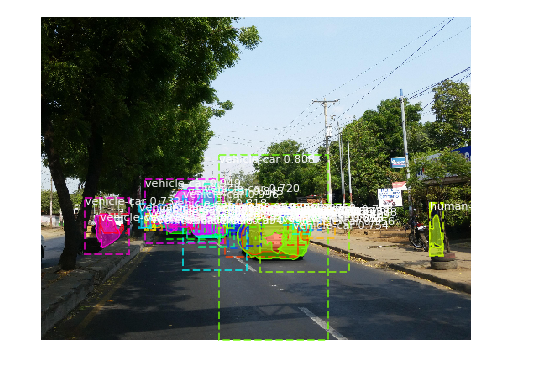

In [9]:
test_img = trainData.load_image(0)
results  = model_infer.detect([test_img], verbose=1)
r = results[0]
print (r['class_ids'], trainData.class_names)
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            valData.class_names, r['scores'], ax=get_ax())

In [25]:
a = sys.modules
for i in a:
    if 'visualize' in i:
        print(i)

src.visualize


In [11]:
del sys.modules['src.visualize']
import src.visualize as visualize

(384, 512, 3)
(384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: (384, 512, 3)
[apply_mask] image: 

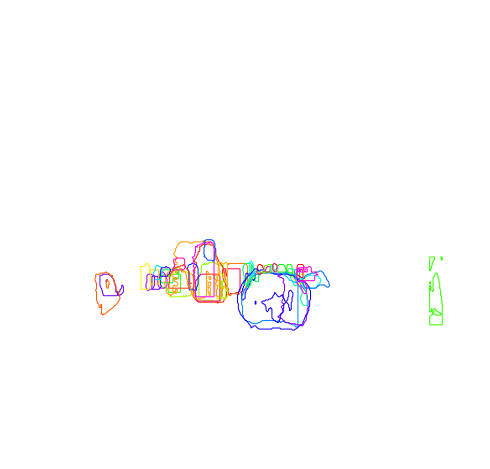

In [12]:
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            valData.class_names, r['scores'], ax=get_ax(),
                            show_captions=False, show_boxes=False, save_fig=True)

In [30]:
test_img.shape

(384, 512, 3)

# SCRATCHPAD

In [ ]:
a = ([1,2,3,4], [1,1])
# zip(*a))
list(zip(*a))

In [ ]:
r['masks']

In [ ]:
molded_images, image_metas, windows = model_infer.mold_inputs([test_img])

In [ ]:
detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, rois, rpn_class, rpn_bbox = model_infer.keras_model.predict([molded_images, image_metas], verbose=0)

In [ ]:
results = []
for i, image in enumerate([test_img]):
    final_rois, final_class_ids, final_scores, final_masks =\
        model_infer.unmold_detections(detections[i], mrcnn_mask[i],
                               image.shape, windows[i])
    results.append({
        "rois": final_rois,
        "class_ids": final_class_ids,
        "scores": final_scores,
        "masks": final_masks,
    })

In [ ]:
mrcnn_mask[0].shape

In [ ]:
test_img.shape